In [12]:
from omegaconf import OmegaConf
from fpf.FixedPoints import FixedPoints
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from nm.model import RNN
import torch.utils
import torch.utils.data
from nm.model import RNN
from nm.tasks import BehavioralTasks
import torch
from hydra import initialize, compose

In [13]:
filepaths = OmegaConf.load("../config/filepaths/filepaths.yaml")

In [25]:
day = '2025-02-18'
time = '18-47-36'
job_nums = [i for i in range(5)]
data = []
fps = []
for jn in job_nums:

    for i in [1, 3]:
        fps_i = FixedPoints()
        fps_i.restore(restore_path=Path(filepaths.models) / day / time / str(jn) / f"fixed_points_beh_nm_ctx_{i}.pickle")
        fps.append(fps_i)
        data.append([jn, i, fps_i.qstar.min(), fps_i.qstar.max(), fps_i.qstar.mean(), fps_i.qstar.std()])
df = pd.DataFrame(data, columns=['job_num', 'task', 'min', 'max', 'mean', 'std'])
df.to_csv(Path(filepaths.models) / day / time / f"q_values_fpf_analysis.csv", index=False, sep=',')
df.head()

,job_num,task,min,max,mean,std
0,0,1,0.676005,1.407373,1.006089,0.100298
1,0,3,0.730892,1.504439,1.008691,0.099744
2,1,1,0.648624,1.480389,1.002052,0.103227
3,1,3,0.715993,1.389306,1.009224,0.097774
4,2,1,0.736228,1.437594,1.005355,0.099598


In [18]:
with initialize(version_base=None, config_path='../config'):
    cfg = compose(config_name='test')

wholepop_dataset = BehavioralTasks(cfg.task)
dataloader = torch.utils.data.DataLoader(wholepop_dataset, batch_size=1, shuffle=False)

model = RNN()
save_path = Path(cfg.filepaths.models) / cfg.day / cfg.time / '0' /  'model_weights.pth'

model.load_state_dict(torch.load(save_path, weights_only=True))
model.eval()

outputs = []
xs = []
rs = []
for i, batch in enumerate(dataloader):
    u, nm_signal, target = batch
    x0 = torch.normal(mean=0, std=1, size=(1, model.dh, 1)) / cfg.model.x0_scl
    output, x = model(u, x0, nm_signal)
    r = torch.sigmoid(x)
    x = x.squeeze().detach().numpy() # (dh x T)
    r = r.squeeze().detach().numpy()
    output = output.squeeze().detach().numpy()
    xs.append(x)
    rs.append(r)
    outputs.append(output)

/home/stef/neuromod25/.venv/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/stef/neuromod25/.venv/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [19]:

def get_mag_dx(xs):
    dxs = [] # dx(t)
    mag_dxs = [] # |dx(t)|
    for x in xs:
        dx = x[:, 1:] - x[:, :-1]
        mag_dx = np.linalg.norm(dx, axis=1)
        dxs.append(x[:, 1:] - x[:, :-1])
        mag_dxs.append(mag_dx)

    return dxs, mag_dxs

dxs, mag_dxs = get_mag_dx(xs)
drs, mag_drs = get_mag_dx(rs)

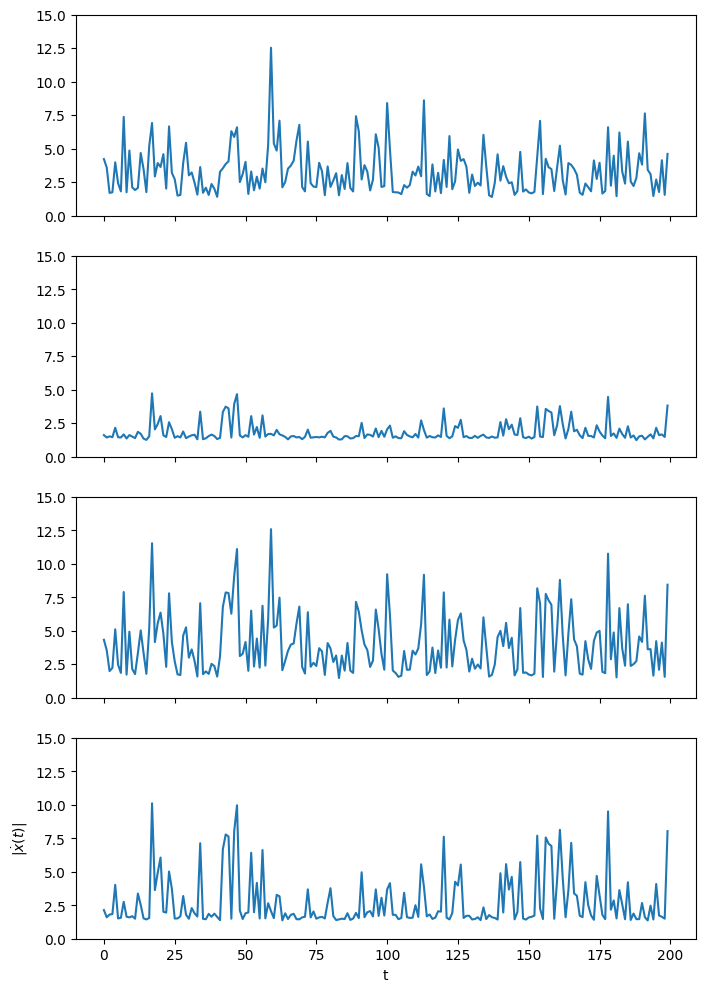

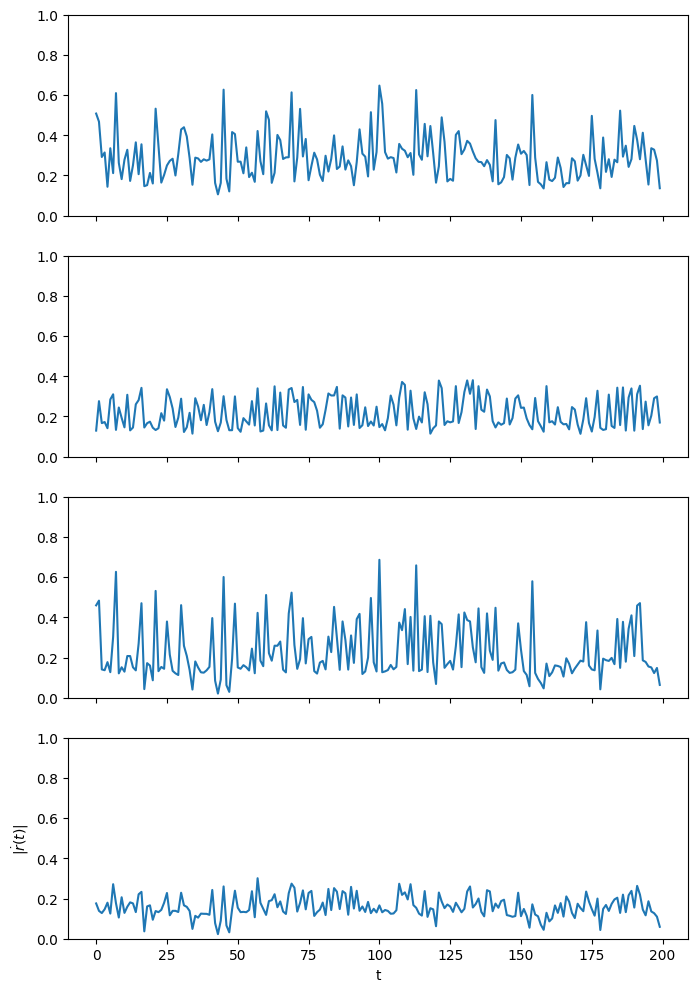

In [23]:
fig, ax = plt.subplots(nrows=4, figsize=(8, 12), sharex=True, sharey=True)
for i, elt in enumerate(mag_dxs):
    ax[i].plot(elt)
ax[-1].set_ylim(0, 15)
ax[-1].set_xlabel("t")
ax[-1].set_ylabel(r'|$\dot{x}(t)$|')
plt.show()

fig, ax = plt.subplots(nrows=4, figsize=(8, 12), sharex=True, sharey=True)
for i, elt in enumerate(mag_drs):
    ax[i].plot(elt)
ax[-1].set_ylim(0, 1)
ax[-1].set_xlabel("t")
ax[-1].set_ylabel(r'|$\dot{r}(t)$|')
plt.show()

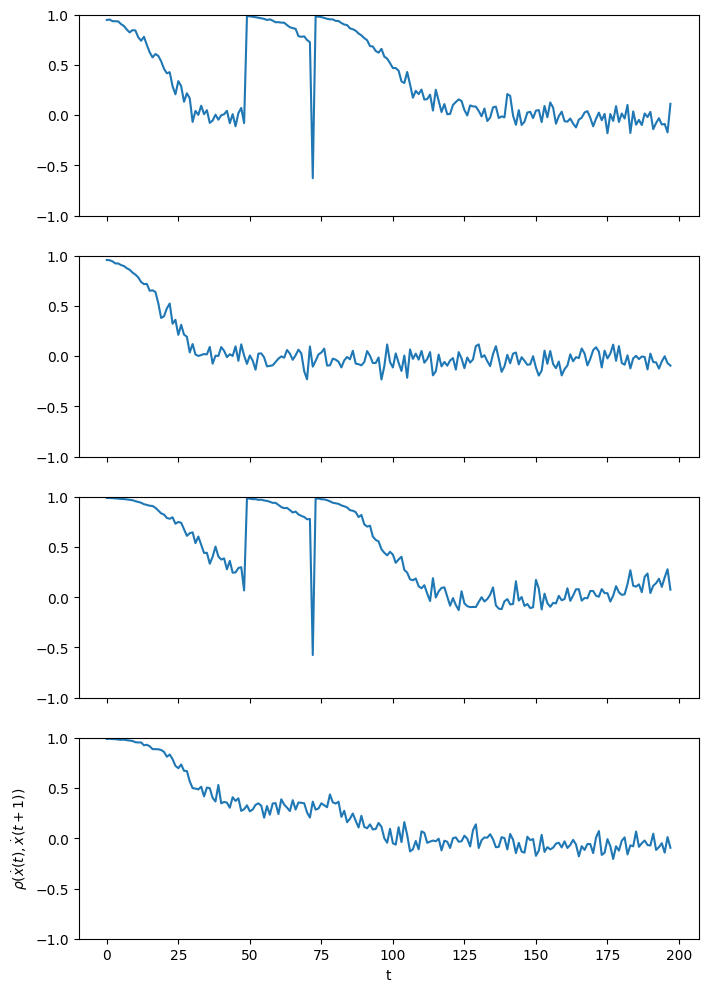

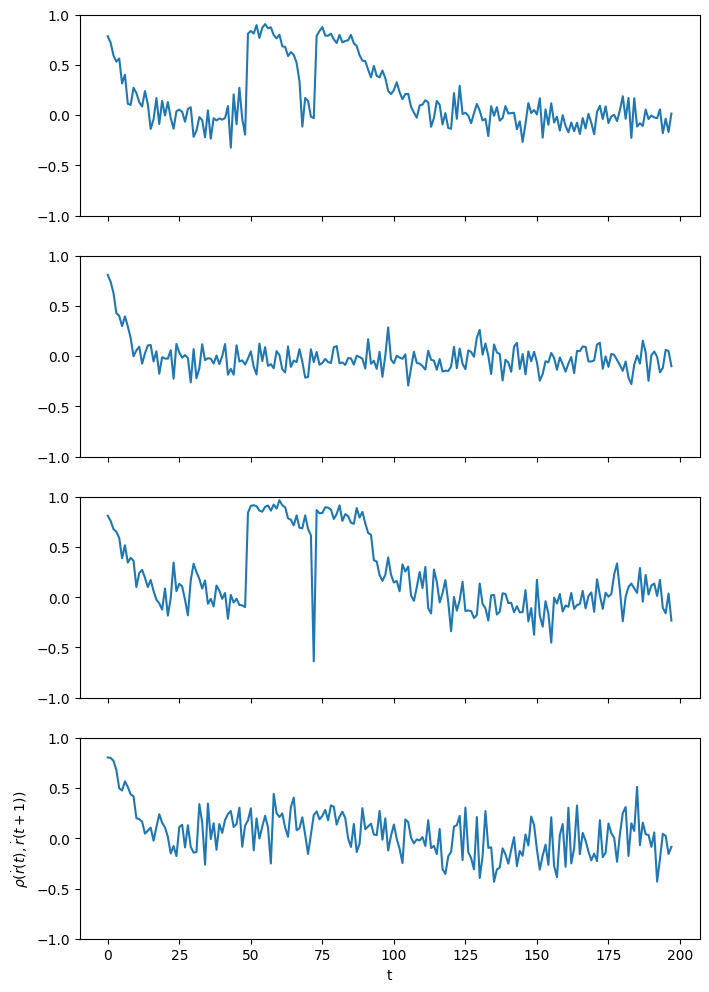

In [21]:
fig, ax = plt.subplots(nrows=4, figsize=(8, 12), sharex=True, sharey=True)
for i, elt in enumerate(dxs):
    elt /= np.linalg.norm(elt, axis=0).reshape(1, -1)
    one_step_corr = np.diag(
        np.matmul(
            elt.T, elt
        ),
        k=1
    )
    ax[i].plot(one_step_corr)
ax[-1].set_ylim(-1, 1)
ax[-1].set_xlabel("t")
ax[-1].set_ylabel(r'$\rho(\dot{x}(t), \dot{x}(t+1))$')
plt.show()

fig, ax = plt.subplots(nrows=4, figsize=(8, 12), sharex=True, sharey=True)
for i, elt in enumerate(drs):
    elt /= np.linalg.norm(elt, axis=0).reshape(1, -1)
    one_step_corr = np.diag(
        np.matmul(
            elt.T, elt
        ),
        k=1
    )
    ax[i].plot(one_step_corr)
ax[-1].set_ylim(-1, 1)
ax[-1].set_xlabel("t")
ax[-1].set_ylabel(r'$\rho(\dot{r}(t), \dot{r}(t+1))$')
plt.show()